W bieżącym rozdziale szczegółowo opisany zostanie proces tworzenia autorskiej głębokiej sieci neuronowej o nazwie GML-Net. Sieć ta została skonstruowana przez autora niniejszej pracy w celu przeprowadzenia efektywnej detekcji budynków na zdjęciach lotniczych pochodzących ze zbioru Inria Aerial Image Labeling Dataset. W pierwszej części rozdziału przedstawione zostaną najważniejsze hiperparametry modelu oraz proces wczytywania, podziału i obróbki danych treningowych i walidacyjnych. W kolejnej części przedstawiona zostanie architektura sieci GML-Net, warstwy przetwarzania (bloki), które tę architekturę tworzą oraz sposób trenowania tej sieci. W ostatniej części rozdziału zaprezentowana zostanie analiza wyników generowanych przez model, w tym sposób łączenia predykcji masek fragmentów obrazu w jedną łączną maskę dla całego obrazu o wysokiej rozdzielczości.

## Najważniejsze hiperparametry sieci

Pierwszym krokiem procesu tworzenia modelu finalnej sieci neuronowej jest definicja bibliotek języka Python, które zostaną wykorzystane w trakcie obliczeń na poszczególnych etapach tworzenia modelu. Główną biblioteką, która została zastosowana w bieżącej pracy do implementacji głębokiego uczenia jest biblioteka PyTorch. Została ona wybrana, gdyż pozwala ona na efektywne i elastyczne posługiwanie się podstawowymi jednostkami przetwarzania w architekturze głębokich sieci neuronowych, zapewnia pełną integrację z biblioteką NumPy oraz umożliwia wygodną definicję zbiorów danych uczących i walidacyjnych.

In [ ]:
import os
import time
import copy
import glob
import torch
import random
import numpy as np
import pandas as pd
from math import exp
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from google.colab import drive
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import Dataset
from torchvision import transforms, models
from numpy.lib.stride_tricks import as_strided
from collections import defaultdict, OrderedDict

Kolejnym krokiem tworzenia sieci GML-Net była definicja jej najważniejszych hiperparametrów, którymi są:
- rozdzielczość fragmentów obrazów, na których trenowana będzie sieć GML-Net (sample\_res), 
- rozdzielczość obrazów na jakie będzie podzielony zostanie obraz wejściowy przed pobraniem z niego próbek sample\_res x sample\_res (sub\_arr\_size),
- rozmiar batcha w data loaderze (batch\_s),
- najważniejsze parametry optymalizatora (learn\_rate, momt, wght\_dec),
- najważniejsze parametry schedulera (step\_s, gamm),
- wagi poszczególnych składowych funkcji strat (wghts\_dict),
- wartość, powyżej której uznajemy że dany piksel został zakwalifikowany jako będący częścią budynku (loss\_thres),
- liczba epok trenowania (epoch\_num),
- minimalna wartość stopy uczenia (optim\_eps). 


In [ ]:
google_path = "/content/drive/My Drive/GSN/Thesis/Dane/AID/"
train_path = "/content/AerialImageDataset/"
mdl_path = "/content/drive/My Drive/GSN/Thesis/Najlepszy model/"
mdl_name = "ResNet50_wide_UNet_depth_3_BottleNeck_BS_18"
org_h_dim = 5000
org_v_dim = 5000
sub_arr_size = 1000
sample_res = 256
recalc_flag = False
batch_s = 18
learn_rate = 0.01
momt = 0.9
wght_dec = 0.0005
step_s = 5
gamm = 0.5
wghts_dict = {"bce": 0.3, "lhl": 0.3, "dice": 0.4}
loss_thres = 0.5
epoch_num = 200
optim_eps = 1e-08

Jak widać wartości zastosowanych hiperparamterów sieci GML-Net w dużej części pokrywają się z wartościami hiperparapetrów obserwowanych w literaturze badawczej - zdecydowano się na obrazy o rozdzielczości 256x256 pikseli, początkową stopę uczenia na poziomie 0,01, momentum wartości 0,9 i spadek wag równy 0,0005.

In [ ]:
params_dict = {}
params_dict["sub_arr_size"] = sub_arr_size
params_dict["sample_res"] = sample_res
params_dict["recalc_flag"] = recalc_flag
params_dict["batch_s"] = batch_s
params_dict["learn_rate"] = learn_rate
params_dict["momt"] = momt
params_dict["wght_dec"] = wght_dec
params_dict["step_s"] = step_s
params_dict["gamm"] = gamm
params_dict["bce"] = wghts_dict["bce"]
params_dict["lhl"] = wghts_dict["lhl"]
params_dict["dice"] = wghts_dict["dice"]
params_dict["loss_thres"] = loss_thres
params_dict["epoch_num"] = epoch_num
params_dict["org_h_dim"] = org_h_dim
params_dict["org_v_dim"] = org_v_dim

Wartości wszystkich hiperparmetrów modelu zostały zapisane w słowniku params\_dict, po to by zawsze mieć pewność przy użyciu jakich hiperparametrów dany model był trenowany.

## Dane uczące i ich transformacje

Pierwszym krokiem przygotowania danych treningowych i walidacyjnych sieci GML-Net był import zbioru treningowego Inria Aerial Image Labeling Dataset z dysku Google na dysk Coloba.

In [ ]:
drive.mount('/content/drive')

if os.path.exists("sample_data"):
  !rm -r sample_data

if not os.path.exists(train_path):
  !cp -R "$google_path" $train_path

curr_wd = os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Pobrany zbiór treningowy składa się ze 180 zdjęć lotniczych pięciu miast: Austin, Chicago, Hrabstwo Kitsap, Tyrol oraz Wiedeń - po 36 zdjęć każdego z miast. Każde z tych zdjęć ma przypisaną do siebie maskę ground truth, która wskazuje które piksele zdjęcia bazowego reprezentują budynki. Zdjęcia bazowe mają rozdzielczość 5000x5000 pikseli, trzy kanały przestrzenne, każde z nich pokrywa teren o powierzchni 1500x1500 m^2. Zbiór walidacyjny został wydzielony ze zbioru treningowego poprzez wybranie pięciu pierwszych zdjęć każdego z miast (zgodnie z podejściem zastosowanym w literaturze badawczej) - w ten sposób powstał finalny zbiór treningowy składający się ze 155 zdjęć oraz finalny zbiór walidacyjny składający się z 25 zdjęć. Opisany tu podział jest realizowany przy pomocy funkcji create\_meta\_info, która tworzy pliki CSV zawierające ścieżki do zdjęć z poszczególnych zbiorów. 

In [ ]:
def create_meta_info(root_directory):    
  l_meta = [] 
  l_meta_t = []
  l_meta_v = []
  os.chdir(root_directory)

  for file in glob.glob("*_GT.tif"):
    mask_path = os.path.join(root_directory, file)
    im_path = os.path.join(root_directory, file[:-7] + ".tif")
    l_meta.append((im_path, mask_path))
    if not im_path[-6].isdigit() and im_path[-5] in ["1", "2", "3", "4", "5"]:
      l_meta_v.append((im_path, mask_path))
    else:
      l_meta_t.append((im_path, mask_path))

  os.chdir(curr_wd)
  if l_meta:
    pd.DataFrame(l_meta).to_csv('m_inf.csv', index=False, header=False)
    pd.DataFrame(l_meta_t).to_csv('m_inf_t.csv', index=False, header=False)
    pd.DataFrame(l_meta_v).to_csv('m_inf_v.csv', index=False, header=False)

Posiadając już zdjęcia podzielone na zbiór treningowy i walidacyjny, kolejnym etapem obróbki danych było wydzielenie odpowiednich próbek z tych zdjęć. W związku z tym, iż zbiór Inria Aerial Image Labeling Dataset składa się ze zdjęć o bardzo wysokiej rozdzielczości i niemożliwe oraz bardzo nieefektywne byłoby przeprowadzenie treningu sieci neuronowej na zdjęciach o rozdzielczości 5000x5000 zdecydowano się na podział tych zdjęć (oraz odpowiadających im masek) na 25 równych części, każda o rozdzielczości 1000x1000 pikseli. Dodatkowo, żeby nie utracić informacji znajdujących się na krawędziach podzielonych zdjęć, ze zdjęć bazowych (oraz z odpowiadających im masek) zdecydowano sie wydzielić kolejnych 16 części (również o rozdzielczości 1000x1000 pikseli) znajdujących się na łączeniach każdych czterech sąsiadujących ze sobą bazowych części. W ten sposób z każdego zdjęcia znajdującego się w bazowym zbiorze treningowym pozyskano 41 fragmentów (oraz 41 fragmentów odpowiadających im masek), co przekłada się na łączną liczbę 6355 fragmentów trenujących (155 * 41). Dodając do tego fakt, iż z każdego takiego fragmentu wybranych zostanie 18 losowych okien (rozmiar partii równy 18) o rozmiarach 256x256 pikseli, uzyskujemy finalnie 114390 przykładów uczących. Pobieranie fragmentów z poszczególnych zdjęć (masek) zostało zrealizowane przy pomocy funkcji resample, która z kolei opiera się na funkcji as\_strided pochodzącej z biblioteki numpy.lib.stride\_tricks.

In [ ]:
def resample(image, N, org_h_dim, org_v_dim):
  wind_h = wind_w = N
  img_shp = image.shape
  nm_cls = img_shp[-1] if len(img_shp) > 2 else 1
  n_arrs1 = int((img_shp[0] // wind_h))
  n_arrs2 = int((img_shp[1] // wind_w))
  s_l = wind_h * org_h_dim * nm_cls
  s_k = wind_w * nm_cls

  if nm_cls == 1:
    new_strds = (s_l, s_k, org_v_dim * nm_cls, nm_cls)
    new_shape = (n_arrs1, n_arrs2, wind_h, wind_w)
    img_winds = as_strided(image, shape=new_shape, strides=new_strds)
    fin_winds = img_winds.reshape((n_arrs1 * n_arrs2, wind_h, wind_w))
  else:
    new_strds = (s_l, s_k, org_v_dim * nm_cls, nm_cls, 1)
    new_shape = (n_arrs1, n_arrs2, wind_h, wind_w, nm_cls)
    img_winds = as_strided(image, shape=new_shape, strides=new_strds)
    fin_winds = img_winds.reshape((n_arrs1*n_arrs2, wind_h, wind_w, nm_cls))
  return fin_winds

Pozyskane fragmenty zdjęć i masek zostały następnie połączone w listy, w celu ułatwienia ich przetwarzania na kolejnych etapach - łączenie to zostało zrealizowane przy pomocy funkcji get\_img\_smpl.

In [ ]:
def get_img_smpl(idx, sub_arr_size, img_arr, org_h_dim, org_v_dim):
  image = np.array(Image.open(img_arr[idx, 0]))
  mask = np.array(Image.open(img_arr[idx, 1]))
  img_sub_arrs1 = resample(image, sub_arr_size, org_h_dim, org_v_dim)
  msk_sub_arrs1 = resample(mask, sub_arr_size, org_h_dim, org_v_dim)
  s1 = list(zip(img_sub_arrs1, msk_sub_arrs1))
  half_wind = int(sub_arr_size // 2)
  img_hv = image[half_wind:-half_wind, half_wind:-half_wind, ...]
  mask_hv = mask[half_wind:-half_wind, half_wind:-half_wind, ...]
  img_sub_arrs2 = resample(img_hv, sub_arr_size, org_h_dim, org_v_dim)
  msk_sub_arrs2= resample(mask_hv, sub_arr_size, org_h_dim, org_v_dim)
  s2 = list(zip(img_sub_arrs2, msk_sub_arrs2))
  return s1, s2

Aby ułatwić proces pobierania fragmentów ze zdjęć i masek bazowych oraz umożliwić ich efektywną augmentację postanowiono połączyć te operacje przy pomocy jednej klasy ResampledImageDataset.

In [ ]:
class ResampledImageDataset(Dataset):
  def __init__(self, csv_file, org_h, org_v, sub_arr_s, transform=None):
    self.img_arr = pd.read_csv(csv_file, header=None).values
    self.trasform = transform
    self.org_h = org_h
    self.org_v = org_v
    self.sub_arr_s = sub_arr_s

  def __len__(self):
    return len(self.img_arr)

  def __getitem__(self, idx):
    s1, s2 = get_img_smpl(idx, self.sub_arr_s, self.img_arr, self.org_h, 
                          self.org_v)   

    if self.trasform is not None:
      s1 = self.trasform(s1)
      s2 = self.trasform(s2)   
    return s1 + s2

Dodatkowo, aby wyliczyć średnią i odchylenie standardowe dla poszczególnych kanałów zdjęć bazowych po to by móc zastosować te statystyki do normalizacji, stworzono klasę BasicImageDataset.

In [ ]:
class BasicImageDataset(Dataset):
  def __init__(self, csv_file, transform=None):
    self.images_arr = pd.read_csv(csv_file, header=None).values
    self.trasform = transform

  def __len__(self):
    return len(self.images_arr)

  def __getitem__(self, idx):
    image = np.array(Image.open(self.images_arr[idx, 0]))
    mask = np.array(Image.open(self.images_arr[idx, 1]))
    sample = [image, mask]

    if self.trasform is not None:
      sample = self.trasform(sample)
    
    return sample

Dla każdego zdjęcia pochodzącego z klasy BasicImageDataset zapisywane są wartości jego kolorów w poszczególnych kanałach, a po przejściu przez wszystkie zdjęcia wyliczane są globalne średnie i odchylenia standardowe dla wszystkich kanałów.

In [ ]:
create_meta_info(train_path)
basic_ds = BasicImageDataset("m_inf.csv")
basic_ds_len = len(basic_ds)
sngl_img_pxl_num = basic_ds[0][0].size
tot_pxl_num = (sngl_img_pxl_num * basic_ds_len) / 3

if recalc_flag:
  mean_rgbs = (np.array([sample[0].sum((0, 1)) for sample in 
                        basic_ds]).sum(0) / tot_pxl_num) / 255
  std_rgbs = np.sqrt(np.array([np.power(sample[0] - mean_rgbs, 2).sum((0, 1)) 
                                        for sample in basic_ds]).sum(0) / 
                                        tot_pxl_num) / 255
else:
  mean_rgbs = np.array([0.40483995, 0.42726254, 0.39271341])
  std_rgbs = np.array([0.45071778, 0.4634665 , 0.42900409])

Kolejnym etapem tworzenia zbiorów treningowego i walidacyjnego jest definicja augmentacji, które zostaną zastosowane na tych zbiorach.

In [ ]:
class RandomHorizontalFlip(object):
  def __init__(self, p=0.5):
    super().__init__()
    self.p = p
  
  def __call__(self, all_samples):
    trans_list = []

    for sample in all_samples:
      image, mask = sample[0], sample[1]
      image = transforms.functional.to_pil_image(image)
      mask = transforms.functional.to_pil_image(mask)

      if torch.rand(1) < self.p:
        image = transforms.functional.hflip(image)
        mask = transforms.functional.hflip(mask)

      trans_list.append((image, mask))

    return trans_list

Pierwszą z nich jest augmentacja realizowana przez losowy horyzontalny obrót zdjęcia (maski) wzdłuż środkowej osi - losowość polega na tym, iż taka augmentacja dochodzi do skutku z prawdopodobieństwem 50% - czyli dla co drugiego zdjęcia.

In [ ]:
class RandomVerticalFlip(object):
  def __init__(self, p=0.5):
    super().__init__()
    self.p = p
  
  def __call__(self, all_samples):
    trans_list = []

    for sample in all_samples:
      image, mask = sample[0], sample[1]

      if torch.rand(1) < self.p:
        image = transforms.functional.vflip(image)
        mask = transforms.functional.vflip(mask)

      trans_list.append((image, mask))

    return trans_list

Drugą zdefiniowaną augmentacją jest losowy wertykalny obrót zdjęcia (maski) wzdłuż środkowej osi, który również jest realizowany z prawdopodobieństwem 50%.

In [ ]:
class RandomRotation(object):
  def __call__(self, all_samples):

    trans_list = []

    for sample in all_samples:
      image, mask = sample[0], sample[1]
      angle_mult = random.randint(0, 12)
      rot_img = transforms.functional.rotate(image, angle_mult * 30, 
                                             expand=True)
      rot_mask = transforms.functional.rotate(mask, angle_mult * 30, 
                                              expand=True)
      trans_list.append((rot_img, rot_mask))
    
    return trans_list

Kolejną augmentacją zdefiniowaną dla zbiorów treningowego i walidacyjnego jest rotacja zdjęcia (maski) o losowy kąt będący wielokrotnością kąta 30 stopni.

In [ ]:
class RandomCrop(object):
  def __init__(self, out_s):
    assert isinstance(out_s, (int, tuple))
    self.out_s = out_s     

  def __call__(self, all_samples):
    trans_list = []

    for sample in all_samples:
      image, mask = np.array(sample[0]), np.array(sample[1])
      out_s = (self.out_s, self.out_s) if isinstance(self.out_s, int) else out_s
      new_h, new_w = out_s
      top = np.random.randint(0, image.shape[0] - new_h)
      left = np.random.randint(0, image.shape[1] - new_w)
      image = image[top:(top + new_h), left: left + new_w]
      mask = mask[top:(top + new_h), left: left + new_w]
      trans_list.append((image, mask))
    
    return trans_list

Następną augmentacją wykorzystywaną przy budowie sieci GML-Net jest wybór losowego okna o rozmiarach 256x256 pikseli. 

In [ ]:
 class Normalize(object):    
  def __init__(self, mean, std, inplace=False):
    self.mean = mean
    self.std = std
    self.inplace = inplace
  
  def __call__(self, all_samples):
    trans_list = []

    for sample in all_samples:
      image, mask = sample[0], sample[1]
      norm_img = transforms.functional.normalize(image / 255.0, self.mean, 
                                                self.std, self.inplace)
      norm_mask = mask / 255.0
      trans_list.append((norm_img, norm_mask))
    
    return trans_list

Ostatnią augmentacją wykorzystywaną w bieżącej pracy jest normalizacja zdjęć przy użyciu globalnych średnich i odchyleń standardowych, których sposób wyliczenia został opisany powyżej.

In [ ]:
class ToTensor(object):
  def __call__(self, all_samples):

    trans_list = []

    for sample in all_samples:
      image, mask = np.array(sample[0]), np.array(sample[1])
      trans_list.append((torch.from_numpy(image).permute(2, 0, 1), 
                          torch.from_numpy(mask)))
    return trans_list

Po zastosowaniu wszystkich augmentacji, należy przekonwertować zdjęcia (maski) z formatu macierzy NumPy do formatu tensora PyTorch tak, żeby mogły one być wykorzystane do trenowania finalnej sieci neuronowej - odpowiedzialną za ten proces jest klasa ToTensor.

In [ ]:
trn_trans = transforms.Compose([RandomHorizontalFlip(), 
                                RandomVerticalFlip(),
                                RandomRotation(), 
                                RandomCrop(sample_res), 
                                ToTensor(), 
                                Normalize(mean_rgbs, std_rgbs)])

train_dataset = ResampledImageDataset("m_inf_t.csv", org_h_dim, 
                                      org_v_dim, sub_arr_size, 
                                      transform=trn_trans)

vld_trans = transforms.Compose([RandomCrop(sample_res), ToTensor(), 
                                Normalize(mean_rgbs, std_rgbs)])
valid_dataset = ResampledImageDataset("m_inf_v.csv", org_h_dim, 
                                      org_v_dim, sub_arr_size, 
                                      transform=vld_trans)

Finalnym krokiem tworzenia zbiorów treningowego i walidacyjnego było zdefiniowanie kolejności poszczególnych augmentacji. Jak widać w przypadku zbioru walidacyjnego augmentacje zostały ograniczone do wyboru losowego okna i normalizacji, po to by móc oceniać jakość modelu na jak najbardziej stabilnych danych.

In [ ]:
org_data_set = ResampledImageDataset("m_inf.csv", org_h_dim, 
                                     org_v_dim, sub_arr_size)
ds_len = len(org_data_set)
rnd_idx = random.randint(0, ds_len - 1)
rnd_idx2 = random.randint(0, len(org_data_set[0]) - 1)
org_img0, org_mask0 = org_data_set[rnd_idx][rnd_idx2]

org_img0_shp = org_img0.shape
org_img = np.zeros((org_img0_shp[0], org_img0_shp[1], 4), dtype=np.uint8)
org_img[..., :3] = org_img0
org_img[..., 3] = 255

plt_org_mask = np.zeros((org_img0_shp[0], org_img0_shp[1], 4), 
                        dtype=np.uint8)
plt_org_mask[..., 0] = org_mask0.squeeze()
plt_org_mask[org_mask0.squeeze() > 0, 3] = 180 

Kolejnym etapem obróbki i wczytywania danych było wyświetlenie losowego zdjęcia wraz z jego maską za zbioru treningowego po to by sprawdzić czy proces generowania danych uczących przebiega poprawnie.

In [ ]:
ds_len2 = len(train_dataset)
rnd_idx21 = random.randint(0, ds_len2 - 1)
rnd_idx22 = random.randint(0, len(train_dataset[0]) - 1)
trans_img0, trans_mask0 = train_dataset[rnd_idx21][rnd_idx22]

trans_img0 = torch.clamp(trans_img0, 0, 1).permute(1, 2, 0).cpu().numpy()
trans_img0_shp = trans_img0.shape
trans_img = np.zeros((trans_img0_shp[0], trans_img0_shp[1], 4))
trans_img[..., :3] = trans_img0
trans_img[..., 3] = 1.0

trans_mask0 = torch.clamp(trans_mask0, 0, 1).cpu().numpy()
plt_trans_mask = np.zeros((trans_img0_shp[0], trans_img0_shp[1], 4))
plt_trans_mask[..., 0] = trans_mask0.squeeze()
plt_trans_mask[trans_mask0.squeeze() > 0.5, 3] = 0.7

Aby móc efektywnie wyświetlić zdjęcie uczące wraz z odpowiadającą mu maską, zdecydowano się przekonwertować je do formatu RBGA po to by następnie móc je zwizualizować przy pomocy funkcji plt z biblioteki matplotlib.pyplot.

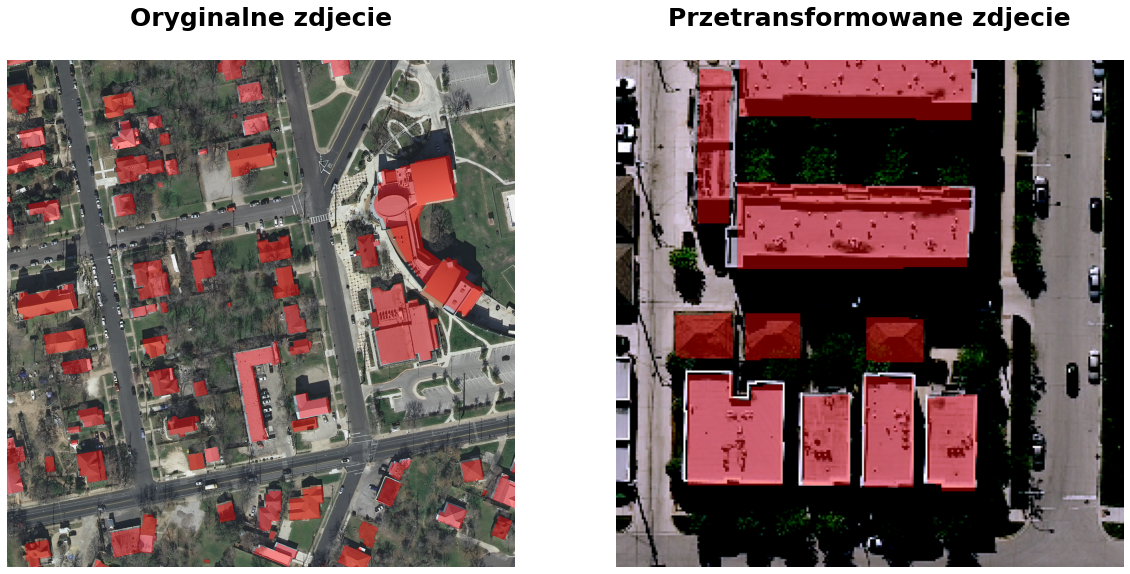

In [ ]:
f2, axarr2 = plt.subplots(nrows=1, ncols=2, figsize=(20, 30))
axarr2[0].set_title("Oryginalne zdjecie\n", color='black', fontweight="bold",
                    fontsize=25)
axarr2[0].imshow(org_img)
axarr2[0].imshow(plt_org_mask, alpha=0.6)
axarr2[0].axis('off')
axarr2[1].imshow(trans_img)
axarr2[1].imshow(plt_trans_mask, alpha=0.6)
axarr2[1].axis('off')
axarr2[1].set_title("Przetransformowane zdjecie\n", color='black', 
                    fontweight="bold", fontsize=25)
plt.savefig('Org_trans_img.png', dpi=300, bbox_inches='tight')

Ostatnim etapem przygotowywania zbiorów treningowych i walidacyjnych było utworzenie dla nich obiektów ładujących dane (ang. data loader), które posłużyły bezpośrednio do zasilenia finalnego modelu w przykłady uczące / walidacyjne.

In [ ]:
train_data_gen = torch.utils.data.DataLoader(train_dataset, shuffle=True, 
                                             batch_size=batch_s, 
                                             num_workers=2, 
                                             pin_memory=True, 
                                             drop_last=True)

valid_data_gen = torch.utils.data.DataLoader(valid_dataset, 
                                             batch_size=batch_s, 
                                             num_workers=2, 
                                             pin_memory=True, 
                                             drop_last=True)

dataset_sizes = {'Train': len(train_data_gen.dataset), 'Valid': 
                 len(valid_data_gen.dataset)}

data_loaders = {'Train': train_data_gen, 'Valid': valid_data_gen}

Po ustrukturyzowaniu procesu wczytywania i obróbki danych, kolejnym krokiem  w budowie modelu detekcji budynków na zdjęciach lotniczych, była definicja finalnej architektury sieci GML-Net.

## Architektura sieci

Architektura sieci GML-Net wzorowana jest na architekturze U-Net, jest jednak od niej płytsza o jeden poziom ekstrakcji cech / upsamplingu, stąd też występują w niej tylko trzy połączenia rezydualne. Rolę enkodera w sieci GML-Net pełni sieć Wide ResNet-50-2, która tym różni się od zwykłej sieci ResNet-50, że posiada dwa razy więcej map cech w blokach rezydualnych, co czyni ją sporo szerszą i w efekcie skuteczniejszą w wychwytywaniu ukrytych zależności. Cechy wyekstraktowane przy pomocy Wide ResNet-50-2 na danym poziomie rozdzielczości przestrzennej są następnie przetwarzane przez blok BottleNeck (wzorowany na blokach sieci OSNet) po to by uzyskać zagregowany zbiór cech z przekroju różnych skal. Zbiór ten jest następnie transferowany, przy pomocy połączeń rezydualnych, bezpośrednio do warstw dekodera. Rekonstrukcja cech w dekoderze przeprowadzana jest przy pomocy konwolucji transponowanej. Zrekonstruowane cechy są przetwarzane przez blok BottleNeck, a następnie przeprowadzana jest ich konkatenacja z cechami uzyskanymi z enkodera - tak połączone mapy cech stają się wsadem do kolejnych, wyższych warstw dekodera. W całej sieci powszechnie wykorzystywane są konwolucje separowalne wgłębnie i punktowo, co pozwala sieci GML-Net efektywnie nauczyć się korelacji kanałów przestrzennych, uniknąć nadmiernego dopasowania oraz uzyskać większą efektywność obliczeniową. Stąd też pomimo wykorzystania stosunkowo cieżkich architektur jakimi są bez wątpienia U-Net i Wide ResNet-50-2, udało się ograniczyć liczbę trenowalnych parametrów finalnego modelu GML-Net do 27 milionów. Sieć GML-Net składa się z kilku podstawowych bloków przetwarzania stworzonych z wartstw konwolucyjnych, grupujących, aktywacyjnych i normalizacyjnych. Pierwszym z nich i najbardziej podstawowym jest LightConvBlock, czyli blok splotowy, wykorzystujący konwolucję separowalną wgłębnie oraz konwolucję z filtrem o rozmiarze 1x1 w celu efektywnego obliczeniowo tworzenia map cech.

In [ ]:
class LightConvBlock(nn.Module):
  def __init__(self, in_ch, out_ch, k_size, pad, bn_flag):
    super(LightConvBlock, self).__init__()

    self.conv1x1 = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0, bias=False)
    self.conv2 = nn.Conv2d(out_ch, out_ch, k_size, stride=1, padding=pad, 
                           bias=False, groups=out_ch)
    self.bn = nn.BatchNorm2d(out_ch)
    self.relu = nn.ReLU(inplace=True)
    self.bn_flag = bn_flag

  def forward(self, in_tensor):
    out_tens = self.conv1x1(in_tensor)
    out_tens2 = self.conv2(out_tens)
    out_tens2 = self.bn(out_tens2) if self.bn_flag else out_tens2
    return self.relu(out_tens2)

Drugim podstawowym blokiem sieci GML-Net jest UpsamplBlock, czyli blok wykorzystywany w dekoderze, którego zadaniem jest nadpróbkowanie tensorów o niższej rozdzielczości przestrzennej do wyższej rozdzielczości. W tym celu blok ten korzysta z zaprezentowanego powyżej bloku LightConvBlock oraz z konwolucji transponowanej o filtrze rozmiaru 2 i o kroku filtra równym 2.

In [ ]:
class UpsamplBlock(nn.Module):
  def __init__(self, in_ch, out_ch, k_size, pad, bn_flag):
    super(UpsamplBlock, self).__init__()

    self.cb = LightConvBlock(in_ch, out_ch, k_size, pad, bn_flag)
    self.conv_up = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=2, 
                                      stride=2)

  def forward(self, in_tensor):
    return self.conv_up(self.cb(in_tensor))

Kolejnym blokiem wykorzystywanym w sieci opisywanej w bieżącym rozdziale jest blok Conv1x1, w ramach którego zaimplementowana została konwolucja z filtrem o rozmiarze 1x1, normalizacja partiami oraz funkcja aktywacji ReLU. Głównym zadaniem realizowanym przez blok Conv1x1 jest redukcja liczby map cech w odpowiednich częściach sieci neuronowej GML-Net.

In [ ]:
class Conv1x1(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, groups=1):
    super(Conv1x1, self).__init__()

    self.conv1x1 = nn.Conv2d(in_channels, out_channels, 1, stride=stride, 
                          padding=0, bias=False, groups=groups)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    return self.relu(self.bn(self.conv1x1(x)))

Blok Conv1x1Linear jest modyfikacją bloku Conv1x1 nieimplementującą funkcji aktywacji oraz niedopuszczającą do zmiany parametru groups konwolucji 1x1. 

In [ ]:
class Conv1x1Linear(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, bn=True):
    super(Conv1x1Linear, self).__init__()

    self.conv = nn.Conv2d(in_channels, out_channels, 1, stride=stride, 
                          padding=0, bias=False)
    self.bn = nn.BatchNorm2d(out_channels) if bn else None

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x) if self.bn is not None else x
    return x

Blok ChannelGate implementuje bramkę agregacji sieci OSNet, jego zadaniem jest połączenie w sposób dynamiczny cech pochodzących z różnych skal poprzez zastosowanie oddzielnej sieci neuronowej o trenowalnych wagach.

In [ ]:
class ChannelGate(nn.Module):
  def __init__(self, in_ch, num_gates=None, gate_act='sigmoid', red=16, 
               lyr_norm=False):
    super(ChannelGate, self).__init__()
    num_gates = in_ch if num_gates is None else num_gates
    self.global_avgpool = nn.AdaptiveAvgPool2d(1)
    self.fc1 = nn.Conv2d(in_ch, in_ch // red, kernel_size=1)
    self.norm1 = nn.LayerNorm((in_ch // red, 1, 1)) if lyr_norm else None
    self.relu = nn.ReLU(inplace=True)
    self.fc2 = nn.Conv2d(in_ch // red, num_gates, kernel_size=1)
    self.gate_act = nn.Sigmoid() if gate_act == 'sigmoid' else \
    nn.ReLU(inplace=True) if gate_act == 'relu' else None 

  def forward(self, x):
    input = x
    x = self.fc1(self.global_avgpool(x))
    x = self.norm1(x) if self.norm1 is not None else x
    x = self.fc2(self.relu(x))
    x = self.gate_act(x) if self.gate_act is not None else x
    return input * x

Ostatnim istotnym elementem sieci GML-Net jest blok BottleNeck\_Block, który analizuje cechy pochodzące z sieci Wide ResNet-50-2 (lub z bloku UpsamplBlock) dla różnych skal, a następnie agreguje je przy pomocy bramki ChannelGate.

In [ ]:
class BottleNeck_Block(nn.Module):
  def __init__(self, in_ch, o_ch, IN=False, btlnck_red=4, **kwargs):
    super(BottleNeck_Block, self).__init__()
    mch = o_ch // btlnck_red
    self.conv1 = Conv1x1(in_ch, mch)
    self.conv2a =  LightConvBlock(mch, mch, 3, 1, True)
    self.conv2b = nn.Sequential(LightConvBlock(mch, mch, 3, 1, True), 
                                LightConvBlock(mch, mch, 3, 1, True))
    self.conv2c = nn.Sequential(LightConvBlock(mch, mch, 3, 1, True), 
                                LightConvBlock(mch, mch, 3, 1, True),
                                LightConvBlock(mch, mch, 3, 1, True))
    self.conv2d = nn.Sequential(LightConvBlock(mch, mch, 3, 1, True), 
                                LightConvBlock(mch, mch, 3, 1, True),
                                LightConvBlock(mch, mch, 3, 1, True), 
                                LightConvBlock(mch, mch, 3, 1, True))
    self.gate = ChannelGate(mch)
    self.conv3 = Conv1x1Linear(mch, o_ch)
    self.downsample = Conv1x1Linear(in_ch, o_ch) if in_ch != o_ch else None
    self.IN = nn.InstanceNorm2d(o_ch, affine=True) if IN else None
    self.relu = nn.ReLU(inplace=True)

In [ ]:
def BottleNeck_forward(self, x):
  inpt = x
  x1 = self.conv1(x)
  x2a = self.conv2a(x1)
  x2b = self.conv2b(x1)
  x2c = self.conv2c(x1)
  x2d = self.conv2d(x1)
  x2 = self.gate(x2a) + self.gate(x2b) + self.gate(x2c) + self.gate(x2d)
  x3 = self.conv3(x2)
  inpt = self.downsample(inpt) if self.downsample is not None else inpt
  out = x3 + inpt
  out = self.IN(out) if self.IN is not None else out
  return self.relu(out)

BottleNeck_Block.forward = BottleNeck_forward

Jak już wcześniej wspominano sieć GML-Net w części związanej z ekstrakcją cech opiera się na sieci Wide ResNet-50-2 wytrenowanej na zbiorze ImageNet. Nie korzysta jednak z całości jej architektury - zatrzymuje się na poziomie 1024 map cech, po to aby ograniczyć liczbę trenowalnych parametrów. Proces ekstrakcji cech przebiega w czterech etapach: 

1.   Ektrakcja 64 map cech o rozdzielczości przestrzennej 128x128.
2.   Ektrakcja 256 map cech o rozdzielczości przestrzenne 64x64.
3.   Ektrakcja 512 map cech o rozdzielczości przestrzennej 32x32.
4.   Ektrakcja 1024 map cech o rozdzielczości przestrzennej 16x16.

W ramach każdego z tych etapów wyekstraktowane cechy są przesyłane przy pomocy połączeń rezydualnych do bloków BottleNeck\_Block po czym tak przetworzone są konkatenowane z blokami BottleNeck\_Block uzyskanymi w ramach pracy dekodera.


In [ ]:
class GML_Net(nn.Module):
  def __init__(self, layrs_dict):
    super().__init__()
    [setattr(self, l_name, l_def) for l_name, l_def in layrs_dict.items()]

rs_lyrs = list(models.wide_resnet50_2(pretrained=True).children())
net_ls = OrderedDict({})
net_ls['l0'] = nn.Sequential(*rs_lyrs[:3])
net_ls['l1'] = nn.Sequential(*rs_lyrs[3:5])
net_ls['l2'] = rs_lyrs[5]
net_ls['l3'] = rs_lyrs[6]
net_ls['bt_nk0'] = BottleNeck_Block(64, 64)
net_ls['bt_nk1'] = BottleNeck_Block(256, 128)
net_ls['bt_nk2'] = BottleNeck_Block(512, 256)
net_ls['bt_nk3'] = BottleNeck_Block(1024, 512)

In [ ]:
def GML_Net_fwd_enc(self, input):
  l0 = self.l0(input)
  bt_l0 = self.bt_nk0(l0)
  l1 = self.l1(l0)
  bt_l1 = self.bt_nk1(l1)
  l2 = self.l2(l1)
  bt_l2 = self.bt_nk2(l2)
  l3 = self.l3(l2)
  bt_l3 = self.bt_nk3(l3)

  return bt_l0, bt_l1, bt_l2, bt_l3

W części dekodera związanej z rekonstrukcją, mapy cech są nadpróbkowane przy pomocy UpsamplBlock po czym są przetwarzane przez BottleNeck\_Block i konkatenowane z cechami pochodzącymi z enkodera i w ten sposób trafiają do wyższych warstw nadpróbkujących.

In [ ]:
n_class = 1
net_ls ['up_smpl_0'] = UpsamplBlock(512, 256, 1, 0, False)
net_ls ['up_smpl_1'] = UpsamplBlock(448, 192, 3, 1, True)
net_ls ['up_smpl_2'] = UpsamplBlock(256, 128, 3, 1, True)
net_ls ['up_smpl_3'] = UpsamplBlock(128, 64, 3, 1, True)
net_ls ['up_bt_nk0'] = BottleNeck_Block(256, 192)
net_ls ['up_bt_nk1'] = BottleNeck_Block(192, 128)
net_ls ['up_bt_nk2'] = BottleNeck_Block(128, 64)
net_ls ['up_bt_nk3'] = BottleNeck_Block(64, 64)
net_ls ['cb_in0'] = LightConvBlock(3, 64, 3, 1, True)
net_ls ['cb_in1'] = LightConvBlock(64, 64, 3, 1, True)
net_ls ['cb_fin0'] = LightConvBlock(128, 64, 3, 1, True)
net_ls ['out_conv'] = nn.Conv2d(64, n_class, 1)

In [ ]:
def GML_Net_fwd_dec(self, bt_l0, bt_l1, bt_l2, bt_l3):
  up_l0 = self.up_smpl_0(bt_l3)
  cat_lyr0 = torch.cat([self.up_bt_nk0(up_l0), bt_l2], dim=1)
  up_l1 = self.up_smpl_1(cat_lyr0)
  cat_lyr1 = torch.cat([self.up_bt_nk1(up_l1), bt_l1], dim=1)
  up_l2 = self.up_smpl_2(cat_lyr1)
  cat_lyr2 = torch.cat([self.up_bt_nk2(up_l2), bt_l0], dim=1)
  up_l3 = self.up_smpl_3(cat_lyr2)

  return up_l3

Po przejściu przez wszystkie warstwy dekodujące sieci GML-Net liczba map cech zostaje zredukowana, przy pomocy bloków LightConvBlock, do jednej. Dzieje sie tak, gdyż celem sieci jest wygenerowanie maski, która po przetworzeniu przy pomocy funkcji sigmoid, wskaże prawdopodobieństwo, że dany piksel reprezentuje budynek. 

In [ ]:
def GML_Net_forward(self, input):
  bt_l0, bt_l1, bt_l2, bt_l3 = GML_Net_fwd_enc(self, input)

  up_l3 = GML_Net_fwd_dec(self, bt_l0, bt_l1, bt_l2, bt_l3)
  cat_lyr3 = torch.cat([self.up_bt_nk3(up_l3), self.cb_in1(self.cb_in0(input))],
                       dim=1)
  
  fin_lyr = self.out_conv(self.cb_fin0(cat_lyr3))
  fin_pred = torch.squeeze(fin_lyr)
  return fin_pred

GML_Net.forward = GML_Net_forward

Po ustrukturyzowaniu procesu przetwarzania danych uczących (walidacyjnych) i po zdefiniowaniu finalnej architektury sieci GML-Net, kolejnym istotnym krokiem w procesie tworzenia głębokiej sieci neuronowej jest usystematyzowanie procesu jej trenowania.  

## Trenowanie sieci

Pierwszym krokiem definicji procesu uczenia się głębokiej sieci neuronowej jest wybór odpowiedniej, do zadania realizowanego przez daną sieć neuronową, funkcji strat. W przypadku sieci GML-Net zdecydowano się, po przeanalizowaniu dostępnej literatury badawczej, iż sieć ta zostanie wytrenowana przy pomocy funkcji strat stanowiącej ważoną sumę binarnej entropii skrośnej, Dice Loss oraz Lovász Hinge Loss. Po przeprowadzeniu licznych eksperymentów, ustalono iż optymalne wagi poszczególnych części funkcji strat to: 0,3 dla BCE, 0,4 dla DL oraz 0,3 dla LHL. W ten sposób powstała finalna funkcja strat o następującej definicji: 

\begin{equation}
LF = 0,3 * BCE + 0,4 * DL + 0,3 * LHL
\end{equation}


In [ ]:
def bce_loss_func(pred, target, stats, bce_wght, f_loss):
  if bce_wght > 0.0:
    bce_loss = nn.functional.binary_cross_entropy_with_logits(pred, target)
    stats['BCE Loss'] += bce_loss.data.cpu().numpy() * target.size(0)
    f_loss += (bce_loss * bce_wght)
  
  return f_loss

Binarna entropia skrośna jest wyliczana przy pomocy funkcji  pochodzącej z biblioteki torch.nn.functional o nazwie binary\_cross\_entropy\_with\_logits, zgodnie ze wzorem zaprezentowanym w podrozdziale 2.3 niniejszej pracy.

In [ ]:
def dice_loss_func(pred, target, smth, stats, dice_wght, f_loss):
  pred = torch.sigmoid(pred)
  prd2 = pred > loss_thres
  trgt2 = target > loss_thres
  intrs = (prd2 * trgt2).sum([1, 2])
  f1s = torch.true_divide(2. * intrs + smth, prd2.sum([1, 2]) + 
                          trgt2.sum([1, 2]) + smth)

  if dice_wght > 0.0:
    dice_loss = 1 - f1s
    dice_mean_loss = dice_loss.mean()
    stats['Dice Loss'] += dice_loss.sum().data.cpu().numpy()
    f_loss += (dice_mean_loss * dice_wght)
  
  return f_loss, f1s, prd2, trgt2, intrs

Implementacja funkcji Dice Loss zastosowana w bieżącym rozdziale opiera się na wyliczeniu metryki F1 Score a następnie odjęciu jej od wartości 1, po to by sieć ucząc się maksymalizowała wartość współczynnika podobieństwa Sørensena.

In [ ]:
def lovasz_grad(gt_sorted):
  p = len(gt_sorted)
  gts = gt_sorted.sum()
  intersection = gts - gt_sorted.float().cumsum(0)
  union = gts + (1 - gt_sorted).float().cumsum(0)
  jaccard = 1.0 - intersection / union

  if p > 1:
      jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]

  return jaccard

In [ ]:
def lovasz_hinge_loss(org_pred, org_target, stats, lhl_wght, f_loss):
  if lhl_wght > 0.0:
    pred = org_pred.view(-1)
    target = org_target.view(-1)

    if len(target) == 0:
      return pred.sum() * 0.

    signs = 2. * target.float() - 1.0
    errors = (1. - pred * signs)
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = target[perm]
    grad = lovasz_grad(gt_sorted)
    lh_loss = torch.dot(nn.functional.relu(errors_sorted), grad)
    stats['LH Loss'] += lh_loss.data.cpu().numpy() * org_target.size(0)
    f_loss += (lh_loss * lhl_wght)

  return f_loss

Funkcja Lovász Hinge Loss została zaimplementowana zgodnie z jej definicją szeroko opisaną w pracy The Lovasz Hinge: A Novel Convex Surrogate for Submodular Losses napisanej przez Jiaqiana Yu i Matthew B. Blaschko.

In [ ]:
def gaussian(w_s, sigma):
    gauss = torch.Tensor([exp(-(x - w_s // 2) ** 2 / 
                              float(2 * sigma ** 2)) for x in range(w_s)])
    return gauss/gauss.sum()

def create_window(w_s, channel, img1):
  _1D_window = gaussian(w_s, 1.5).unsqueeze(1)
  _2D_window = _1D_window.mm(_1D_window.t()).float()
  _2D_window = _2D_window.unsqueeze(0).unsqueeze(0)
  window = _2D_window.expand(channel, 1, w_s, w_s).contiguous()

  if img1.is_cuda:
      window = window.cuda(img1.get_device())
  window = window.type_as(img1)

  return window

Poza funkcją strat, istotnym elementem treningu głębokiej sieci neuronowej, jest też właściwa definicja metryk oceniających skuteczność generowanych przez tą sieć predykcji. W przypadku sieci GML-Net, po analizie literatury dotyczącej detekcji budynków na zdjęciach lotniczych, zdecydowano się na następujące metryki:

- ogólna dokładność (OA),
- współczynnik podobieństwa Jaccarda (IoU)
-  F1 Score (F1S),
- indeks podobieństwa strukturalnego (SSIM).

In [ ]:
def ssim_index(img1, img2, w_s=11):
  img1 = img1[..., None].float()
  img2 = img2[..., None].float()
  (_, channel, _, _) = img1.size()
  window = create_window(w_s, channel, img1)
  mu1 = nn.functional.conv2d(img1, window, padding = w_s // 2, 
                             groups=channel)
  mu2 = nn.functional.conv2d(img2, window, padding = w_s // 2, 
                             groups=channel)
  sigma1_sq = nn.functional.conv2d(img1 * img1, window, padding = w_s // 2, 
                                   groups=channel) - mu1.pow(2)
  sigma2_sq = nn.functional.conv2d(img2 * img2, window, padding = w_s // 2,
                                   groups=channel) - mu2.pow(2)
  sigma12 = nn.functional.conv2d(img1 * img2, window, padding = w_s // 2, 
                                 groups=channel) - mu1 * mu2
  ssim_map = ((2 * mu1 * mu2 + 0.01 ** 2) * (2 * sigma12 + 0.03 ** 2)
  ) / ((mu1.pow(2) + mu2.pow(2) + 0.01 ** 2) * (sigma1_sq + sigma2_sq + 
                                                0.03 **2))
  return ssim_map.mean()

Każda z przedstawionych powyżej metryk została zaimplementowana zgodnie z odpowiednimi wzorami,które zostały szeroko omówione w podrozdziale 2.3. niniejszej pracy.

In [ ]:
def calc_net_metrics(prd2, trgt2, intrs, smth, stats, f_loss, target):
  union = (prd2 + trgt2).sum([1, 2])
  iou = torch.true_divide(intrs + smth, union + smth)
  acc = torch.true_divide(intrs + (~prd2 * ~trgt2).sum([1, 2]), 
                          prd2[0, ...].numel())
  ssim = ssim_index(prd2, trgt2)

  stats['Final Loss'] += f_loss.data.cpu().numpy() * target.size(0)
  stats['OA'] += acc.sum().cpu().numpy()
  stats['IoU'] += iou.sum().cpu().numpy()
  stats['SSIM'] += ssim.data.cpu().numpy() * trgt2.size(0)

Wyliczone wartości komponentów łącznej funkcji strat oraz wartości poszczególnych metryk podlegają zapisowi w słowniku (stats). Taki zapis jest realizowany dla każdej partii (batcha) przykładów uczących / walidacyjnych w danej epoce obliczeniowej. 

In [ ]:
def loss_calc(pred, target, stats, wghts_dict, loss_thres):
  f_loss = 0.0
  bce_wght = wghts_dict['bce']
  lhl_wght = wghts_dict['lhl']
  dice_wght = wghts_dict['dice']
  smth = 1.0
  
  f_loss = bce_loss_func(pred, target, stats, bce_wght, f_loss)
  f_loss = lovasz_hinge_loss(pred, target, stats, lhl_wght, f_loss)
  f_loss, f1s, prd2, trgt2, intrs = dice_loss_func(pred, target, smth, stats, 
                                                   dice_wght, f_loss)
  stats['F1S'] += f1s.sum().cpu().numpy()

  calc_net_metrics(prd2, trgt2, intrs, smth, stats, f_loss, target)
  
  return f_loss

Po zakończenie danej epoki wartości komponentów funkcji strat są sumowane, a wartości metryk uśredniane, tak żeby móc je zaprezentować jako miernik średniej jakości predykcji w danej epoce obliczeniowej.

In [ ]:
def epoch_stats(stats, epoch_samples, phase, res_dict):
  prnt_text = phase + ": "
  
  for k in list(stats.keys())[:-4]:
    curr_stat = stats[k] / epoch_samples
    if k in res_dict[phase]:
      res_dict[phase][k].append(curr_stat)
    else:
      res_dict[phase][k] = [curr_stat]
    prnt_text += "{}: {:.4f}, ".format(k, curr_stat)  
  prnt_text = prnt_text[:-2] + "\n       "

  for k in list(stats.keys())[-4:]:
    curr_stat = stats[k] / epoch_samples
    if k in res_dict[phase]:
      res_dict[phase][k].append(curr_stat)
    else:
      res_dict[phase][k] = [curr_stat]
    prnt_text += "{}: {:.2%}, ".format(k, curr_stat)
  print(prnt_text[:-2])

Jeżeli w danej epoce na zbiorze walidacyjnym uda się osiągnąć najniższą odnotowaną dotąd wartość łącznej funkcji strat, to stan sieci GML-Net, który umożliwił osiągnięcie takiego rezultatu, jest zapisywany na dysku Google wraz z hiperparametrami danego obliczenia.

In [ ]:
def save_model(trnd_model, epoch, res_dict):
  curr_date = datetime.now().strftime('%Y_%m_%d')
  curr_mdl_name = mdl_name + " - przeliczenie na " + curr_date
  dict_out = {'model_params': trnd_model.state_dict(), 'optimizer_params': 
              optimizer_ft.state_dict(), 'scheduler_params': 
              scheduler_ft.state_dict(), 'configuration' : params_dict, 
              'stats': res_dict, 'Num of epochs': epoch}

  torch.save(dict_out, mdl_path + curr_mdl_name + ".pth")

  dummy_input = torch.randn(1, 3, sample_res, sample_res).cuda()
  input_names = ["Input tensor"]
  output_names = ["Output mask"]

  torch.onnx.export(trnd_model, dummy_input, mdl_path + curr_mdl_name + 
                    ".onnx", input_names=input_names, 
                    output_names=output_names, export_params=True)

Dzięki zapisowi stanu najlepszego modelu możliwe jest późniejsze uzyskiwanie z niego predykcji oraz w razie potrzeby kontynuacja trenowania.

In [ ]:
def save_best_res(phase, sched, epoch_loss, best_loss, model, epoch, res_dict,
                  best_model_wts):
  
  if phase == 'Valid' and sched:
    sched.step(epoch_loss)
    
  print("")

  if phase == 'Valid' and epoch_loss < best_loss:
    print("Najlepszy jak dotad model!")
    best_loss = epoch_loss
    best_model_wts = copy.deepcopy(model.state_dict())
    save_model(model, epoch, res_dict)
    
  return best_loss, best_model_wts

Rozpoczęcie każdej epoki obliczeniowej wiąże sie z deklaracją wartości początkowych komponentów funkcji strat oraz metryk jakości predykcji.

In [ ]:
def phase_init(phase, optim, model):
  stats = defaultdict(float)
  stats['BCE Loss'] = 0.0
  stats['LH Loss'] = 0.0
  stats['Dice Loss'] = 0.0
  stats['Final Loss'] = 0.0
  stats['OA'] = 0.0
  stats['IoU'] = 0.0
  stats['F1S'] = 0.0
  epoch_samples = 0

  if phase == 'Train':    
    for param_group in optim.param_groups:
      print("Learning Rate: " + str(param_group['lr']) + '\n')
    model.train() 
  else:
    model.eval()

  return stats, epoch_samples

Funkcja calc\_epoch\_loss w ramach trenowania sieci GML-Net odpowiada za bieżące generowanie predykcji z tej sieci oraz porównywanie ich do oczekiwanych predykcji poprzez wyliczenie wartości łącznej funkcji strat oraz wartości poszczególnych metryk.

In [ ]:
def calc_epoch_loss(phase, optim, model, stats, wghts_dict, loss_thres, 
                    epoch_samples, res_dict):
  for package in data_loaders[phase]:
    for inputs, masks in package:
      inputs = inputs.to(device)
      masks = masks.to(device)
      optim.zero_grad()

      with torch.set_grad_enabled(phase == 'Train'):
        outputs = model(inputs)
        loss = loss_calc(outputs, masks, stats, wghts_dict, loss_thres)

        if phase == 'Train':
          loss.backward()
          optim.step()

      epoch_samples += inputs.size(0)

  epoch_stats(stats, epoch_samples, phase, res_dict)
  return stats['Final Loss'] / epoch_samples

Funkcje train\_init, epoch\_init oraz print\_epoch\_time są funkcjami pomocniczymi w procesie trenowania sieci GML-Net, odpowiadają one za inicjalizację niektórych parametrów oraz wydruk statystyk przeliczeń w poszczególnych epokach.

In [ ]:
def train_init(model):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 1e10
  phases_list = ['Train', 'Valid']
  res_dict = {'Train': {}, 'Valid': {}}

  return best_loss, phases_list, res_dict

def epoch_init(epoch, num_ep):
  print('\nEpoka {}/{}'.format(epoch, num_ep))
  print('-' * 10)
  since = time.time()
  return since

def print_epoch_time(since):
  time_e = time.time() - since
  print('Czas przeliczenia biezacej epoki: {:.0f}m {:.0f}s'.format(time_e // 60,
                                                                   time_e % 60))
  print('-' * 10)

Funkcja train\_model, jest główną funkcją realizującą trenowanie omawianej w bieżącym rozdziale głębokiej sieci neuronowej. Jej głównym zadaniem jest kierowanie kolejnością obliczeń w ramach poszczególnych epok i faz obliczeniowych (treningowej i walidacyjnej).

In [ ]:
def train_model(model, optim, sched, device, wghts_dict, loss_thres, num_ep):
  best_loss, phases_list, res_dict = train_init(model)
  best_model_wts = model.state_dict()

  for epoch in range(1, num_ep + 1):
    since = epoch_init(epoch, num_ep)
    for phase in phases_list:
      stats, epoch_samples = phase_init(phase, optim, model)
      epoch_loss = calc_epoch_loss(phase, optim, model, stats, wghts_dict, 
                                   loss_thres, epoch_samples, res_dict)
      best_loss, best_model_wts = save_best_res(phase, sched, epoch_loss, 
                                                best_loss, model, epoch, 
                                                res_dict, best_model_wts)
    print_epoch_time(since)
    
  print('\nNajnizsza strata wyliczona na zbiorze walidacyjnym: {:4f}'.format(
      best_loss))

  model.load_state_dict(best_model_wts)
  return model, res_dict

Po zdefiniowaniu funkcji treningowej, przed przystąpieniem do właściwego procesu trenowania, należy jeszcze wybrać optymalizator, który takie trenowanie będzie realizował a także scheduler, który będzie odpowiedzialny za odpowiednie obniżanie stopy uczenia w trakcie trenowania. Po przeprowadzeniu eksperymentów z kilkoma różnymi optymalizatorami oraz po przeanalizowaniu literatury badawczej, jako optymalizator najlepiej realizujący trenowanie sieci GML-Net wybrano optymalizator SGD z początkową stopą uczenia na poziomie 0,01, momentum o wartości 0,9 i spadkiem wag równym 0,0005. Jako scheduler wybrano ReduceLROnPlateau, ze spadkiem uczenia realizowanym poprzez przemnożenie aktualnej stopy uczenia przez 0,5 przy pięciu epokach bez poprawy stopy uczenia na zbiorze walidacyjnym.

In [ ]:
model_ft = GML_Net(layrs_dict=net_ls)
model_ft = model_ft.cuda()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=learn_rate, 
                         momentum=momt, weight_decay=wght_dec)

scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min', 
                                                    factor=gamm, 
                                                    patience=step_s, 
                                                    eps=optim_eps)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trnd_model, res_dict = train_model(model_ft, optimizer_ft, scheduler_ft, 
                                   device, wghts_dict, loss_thres, 
                                   epoch_num)

In [ ]:
Epoka 155/200
----------
Learning Rate: 4.8828125e-06

Train: BCE Loss: 0.1203, LH Loss: 0.4504, Dice Loss: 0.1532, Final Loss: 0.2325
       OA: 96.88%, IoU: 78.87%, F1S: 84.68%, SSIM: 95.31%

Valid: BCE Loss: 0.1165, LH Loss: 0.4679, Dice Loss: 0.1178, Final Loss: 0.2224
       OA: 97.08%, IoU: 82.42%, F1S: 88.22%, SSIM: 95.46%

Najlepszy jak dotad model!
Czas przeliczenia biezacej epoki: 7m 31s

Najlepszy wynik pod kątem łącznej straty na zbiorze walidacyjnym, sieć GML-Net uzyskała po 155 epokach obliczeniowych. Wartość łącznej funkcji strat wyniosła wtedy 0,2224, a uzyskane metryki były na poziomie: OA = 97,08%, IoU = 82,42%, F1S = 88,22%, SSIM = 95,46%. Uzyskane wartości metryk można uznać za satysfakcjonujące patrząc przez pryzmat wyników uzyskiwanych przez modele zaprezentowane w liteaturze dotyczącej detekcji budynków na zdjęciach lotniczych.

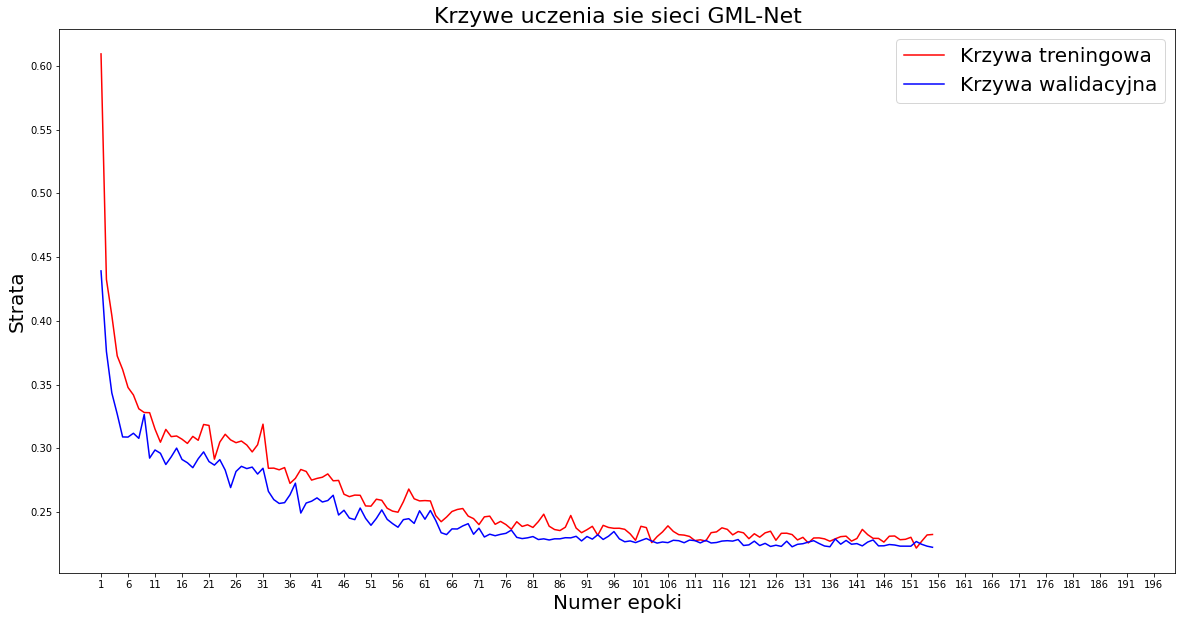

In [ ]:
res_dict = model_dict['stats']
train_loses = res_dict['Train']['Final Loss']
valid_losses = res_dict['Valid']['Final Loss']

plt.plot(*zip(*[(i + 1, loss) for i, loss in enumerate(train_loses)]), '-r')
plt.plot(*zip(*[(i + 1, loss) for i, loss in enumerate(valid_losses)]), '-b')

plt.legend(['Krzywa treningowa', 'Krzywa walidacyjna'], fontsize=20)
plt.title('Krzywe uczenia sie sieci GML-Net', fontsize=22)
plt.xlabel('Numer epoki', fontsize=20)
plt.xticks(range(1, epoch_num + 1))
plt.ylabel('Strata', fontsize=20)
plt.gcf().set_facecolor("white")
plt.gcf().set_size_inches(20, 10)
plt.gca().set_xticks(plt.gca().get_xticks()[::5])
plt.savefig('Krzywe uczenia.png', dpi=300, bbox_inches='tight')

Jak widać na powyższym rysunku, przez cały okres trenowanie sieci GML-Net, wartość łącznej funkcji straty na zbiorze walidacjnym utrzymywała się poniżej wartości łącznej funkcji straty na zbiorze treningowym. Można to tłumaczyć tym, iż zbiór walidacyjny jest kilkukrotnie mniejszy od zbioru treningowego, może więc charakteryzować się mniejszą zmiennością i stąd generować nieznacznie lepsze wyniki. Co istotne w czasie treningu nie dochodzi do przetrenowania sieci - zastosowanie silnej augmentacji danych, przyczyniło się do uzyskania wystarczającej odporności modelu na ten problem.

## Generowanie finalnych predykcji

Zaprezentowany powyżej model GML-Net można by na tym etapie uznać za ukończony, gdyby operował on na obrazach o rozdzielczości 5000x5000. Niestety trenowanie głębokiej sieci neuronowej na obrazach o tak wysokiej rozdzielczości nie jest możliwe ze względu na ograniczoną pojemność kart graficznych, stąd też konieczne było wytrenowanie sieci GML-Net na licznych podpróbkach obrazów oryginalnej rozdzielczości. Aby wygenerować finalną predykcję masek dla obrazów o rozdzielczości 5000x5000 postanowiono więc wygenerować predykcje dla ich podpróbek o rozdzielczości 256x256, a następnie te podpróbki miały zostać połączone w jedną łączną maskę o wysokiej rozdzielczości. Taki proces należałoby powtórzyć dla wszystkich zdjęć znajdujących się w zbiorze walidacyjnym po to aby móc dokładnie określić finalną jakość predykcji sieci GML-Net.

In [ ]:
mdl_from_path = True

if mdl_from_path:
  mdl_n = "ResNet50_wide_UNet_depth_3_BottleNeck_BS_18.pth"
  model_dict = torch.load(mdl_path + mdl_n)
  state_dict = model_dict['model_params']
  trnd_model = GML_Net(layrs_dict=net_ls)
  trnd_model.load_state_dict(state_dict)
  trnd_model.cuda()
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  trnd_model.eval()

Pierwszym etapem generowania finalnych predykcji było wczytanie zapisu najlepszego uzyskanego modelu wraz z odpowiednimi jego hiperparametrami oraz ustawienie go w trybie ewaluacji.

In [ ]:
def g_prms(imgs_arr, img_num):
  mask_path = imgs_arr[img_num, 1]
  image = np.array(Image.open(imgs_arr[img_num, 0]))
  mask = np.array(Image.open(mask_path))
  wind_h = sample_res
  wind_w = sample_res
  img_shp = image.shape
  nm_cls = img_shp[-1] if len(img_shp) > 2 else 1
  img_h = img_shp[0]
  img_w = img_shp[1]
  S_y = sample_res // 2
  S_x = sample_res // 2
  return image, mask, wind_h, wind_w, nm_cls, img_h, img_w, S_y, S_x

Przy pomocy funkcji g\_prms ustalono najważniejsze parametry podziału zdjęć pochodzących ze zbioru walidacyjnego na podpróbki o rozdzielczości 256x256. Postanowiono, iż każde zdjęcie zostanie podzielone na 1444 nakładające się podpróbki, szerokość nakładania się ustalono na połowę wymiaru podpróbki.

In [ ]:
def get_wnds(img, msk, wnd_h, wnd_w, nm_cls, img_h, img_w, Sy, Sx):
  G_x = 1 + (img_w - wnd_w) // Sx
  G_y = 1 + (img_h - wnd_h) // Sy
  s_l = Sy * img_w * nm_cls
  s_k = Sx * nm_cls
  s_b = img_w * nm_cls
  s_a = 1 * nm_cls
  img_windows = as_strided(img, shape=(G_y, G_x, wnd_h, wnd_w, nm_cls), 
                          strides=(s_l, s_k, s_b, s_a, 1))
  return img_windows.reshape((G_y * G_x, wnd_h, wnd_w, nm_cls)), G_x, G_y

Przy pomocy funkcji as\_strided pochodzącej z biblioteki numpy.lib.stride\_tricks przeprowadzono podział każdego ze zdjęć walidacyjnych.

In [ ]:
imgs_arr = pd.read_csv("m_inf_v.csv", header=None).values
img_n = 1
img, msk, wnd_h, wnd_w, nm_cls, img_h, img_w, Sy, Sx = g_prms(imgs_arr, 
                                                              img_n)
wnd_img, Gx, Gy = get_wnds(img, msk, wnd_h, wnd_w, nm_cls, img_h, img_w, 
                           Sy, Sx)
fig, axs = plt.subplots(Gx, Gy)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.set_size_inches(20, 20)

for i, ax in enumerate(axs.flat):  
  ax.imshow(wnd_img[i])
  ax.axis('off')

plt.savefig('Podprobki.png', dpi=300, bbox_inches='tight')

Aby mieć pewność, że podział został przeprowadzony prawidłowo postanowiono zilustrować go przy pomocy mozaiki składającej się z wszystkich podpróbek wybranego zdjęcia.

Mając do dyspozycji wszystkie 1444 podpróbki zdjęcia bazowego można było przystąpić do generowania predykcji masek dla każdej z tych podpróbek.

In [ ]:
def get_all_preds(reshp_img):
  fin_trans = transforms.Compose([transforms.ToTensor(), 
                                  transforms.Normalize(mean_rgbs, std_rgbs)])
  fin_preds = np.zeros((reshp_img.shape[0], sample_res, sample_res))

  for i in range(0, reshp_img.shape[0], batch_s):
    if i + batch_s > reshp_img.shape[0]:
      continue
    input = reshp_img[i:(i + batch_s), ...]
    trans_input = torch.zeros((input.shape[0], input.shape[3], input.shape[1], 
                              input.shape[2]))
    for j in range(input.shape[0]):
      trans_input[j, ...] = fin_trans(input[j, ...])
    with torch.no_grad():
      pred_base = trnd_model(trans_input.to(device))

    pred_sigm = torch.sigmoid(pred_base).data.cpu().numpy()
    fin_preds[i:(i + batch_s), ...] = pred_sigm
    
  return fin_preds

Aby móc efektywnie połączyć uzyskane predykcje w jedną łączną maskę o rozdzielczości 5000x5000 postanowiono skorzystać z dwuwymiarowych okien Hanna zdefiniowanych szerzej w artykule Nicolasa Pielawskiego oraz Caroliny Wählby Introducing Hann windows for reducing edge-effects in patch-based image segmentation.

In [ ]:
hann_wnd_b = np.zeros((sample_res, sample_res), dtype=float)
hann_wnd_up = np.zeros((sample_res, sample_res), dtype=float)
hann_wnd_down = np.zeros((sample_res, sample_res), dtype=float)
hann_wnd_left = np.zeros((sample_res, sample_res), dtype=float)
hann_wnd_right = np.zeros((sample_res, sample_res), dtype=float)
hann_wnd_up_l = np.zeros((sample_res, sample_res), dtype=float)
hann_wnd_down_l = np.zeros((sample_res, sample_res), dtype=float)
hann_wnd_up_r = np.zeros((sample_res, sample_res), dtype=float)
hann_wnd_down_r = np.zeros((sample_res, sample_res), dtype=float)

Autorzy tego artykułu zaproponowali algorytm łączenia podpróbek zdjęć w jedno łączne zdjęcie w czasie realizowania zadań z zakresu semantycznej segmentacji. Ich pomysł opierał się na przemnażaniu predykcji uzyskanych dla poszczególnych podpróbek przez dwuwymiarowe okna Hanna, stanowiące de facto macierz wag, która główny nacisk kładzie predykcje znajdujące się w środku podpróbki - w ten sposób redukowany jest efekt złych predykcji krawędzi.

In [ ]:
def hann_up_down_left_right(i, j, h_part, v_part):
  if j < sample_res / 2:
    hann_wnd_up[j, i] = 0.5 * h_part
  else:
    hann_wnd_up[j, i] = 0.25 * h_part * v_part
  
  if j > sample_res / 2:
    hann_wnd_down[j, i] = 0.5 * h_part
  else:
    hann_wnd_down[j, i] = 0.25 * h_part * v_part

  if i < sample_res / 2:
    hann_wnd_left[j, i] = 0.5 * v_part
  else:
    hann_wnd_left[j, i] = 0.25 * h_part * v_part
  
  if i > sample_res / 2:
    hann_wnd_right[j, i] = 0.5 * v_part
  else:
    hann_wnd_right[j, i] = 0.25 * h_part * v_part

Nicolas Pielawski i Caroline Wählby zaproponowali również modyfikacje bazowego dwuwymiarowego okna Hanna, dla przypadków gdy predykcja pochodzi z podpróbki znajdującej się na krawędzi zdjęcia bazowego, tak żeby w takich przypadkach położyć nacisk na predykcje znajdujące się na krawędziach podpróbki.

In [ ]:
def hann_up_l_up_r(i, j, h_part, v_part):
  if i <= sample_res / 2 and j <= sample_res / 2:
    hann_wnd_up_l[j, i] = 1
  elif i > sample_res / 2 and j < sample_res / 2:
    hann_wnd_up_l[j, i] = 0.5 * h_part
  elif i < sample_res / 2 and j > sample_res / 2:
    hann_wnd_up_l[j, i] = 0.5 * v_part
  else:
    hann_wnd_up_l[j, i] = 0.25 * h_part * v_part

  if i >= sample_res / 2 and j <= sample_res / 2:
    hann_wnd_up_r[j, i] = 1
  elif i < sample_res / 2 and j < sample_res / 2:
    hann_wnd_up_r[j, i] = 0.5 * h_part
  elif i > sample_res / 2 and j > sample_res / 2:
    hann_wnd_up_r[j, i] = 0.5 * v_part
  else:
    hann_wnd_up_r[j, i] = 0.25 * h_part * v_part

W ten sposób uzyskano 9 wariantów dwuwymiarowego okna Hanna, których zastosowanie zależało od tego gdzie dana podpróbka znajduje się na obrazie bazowym. Funkcje hann\_up\_down\_eft\_right, hann\_up\_l\_up\_r oraz hann\_down\_r\_down\_l zawierają implementacje poszczególnych dwuwymiarowych okien Hanna.

In [ ]:
def hann_down_r_down_l(i, j, h_part, v_part):
  if i >= sample_res / 2 and j >= sample_res / 2:
    hann_wnd_down_r[j, i] = 1
  elif i < sample_res / 2 and j > sample_res / 2:
    hann_wnd_down_r[j, i] = 0.5 * h_part
  elif i > sample_res / 2 and j < sample_res / 2:
    hann_wnd_down_r[j, i] = 0.5 * v_part
  else:
    hann_wnd_down_r[j, i] = 0.25 * h_part * v_part

  if i <= sample_res / 2 and j >= sample_res / 2:
    hann_wnd_down_l[j, i] = 1
  elif i > sample_res / 2 and j > sample_res / 2:
    hann_wnd_down_l[j, i] = 0.5 * h_part
  elif i < sample_res / 2 and j < sample_res / 2:
    hann_wnd_down_l[j, i] = 0.5 * v_part
  else:
    hann_wnd_down_l[j, i] = 0.25 * h_part * v_part

Rysunek poniżej prezentuje wizualizację wszystkich dziewięciu okien Hanna, które w dalszej części niniejszego podrozdziału posłużą do połączenia predykcji podpróbek w jedną łączną maskę.

In [ ]:
for i in range(sample_res):
  for j in range(sample_res):
    h_part = (1 - np.cos((2 * np.pi * i) / (sample_res - 1)))
    v_part = (1 - np.cos((2 * np.pi * j) / (sample_res - 1)))
    hann_wnd_b[j, i] = 0.25 * h_part * v_part
    hann_up_down_left_right(i, j, h_part, v_part)
    hann_up_l_up_r(i, j, h_part, v_part)
    hann_down_r_down_l(i, j, h_part, v_part)

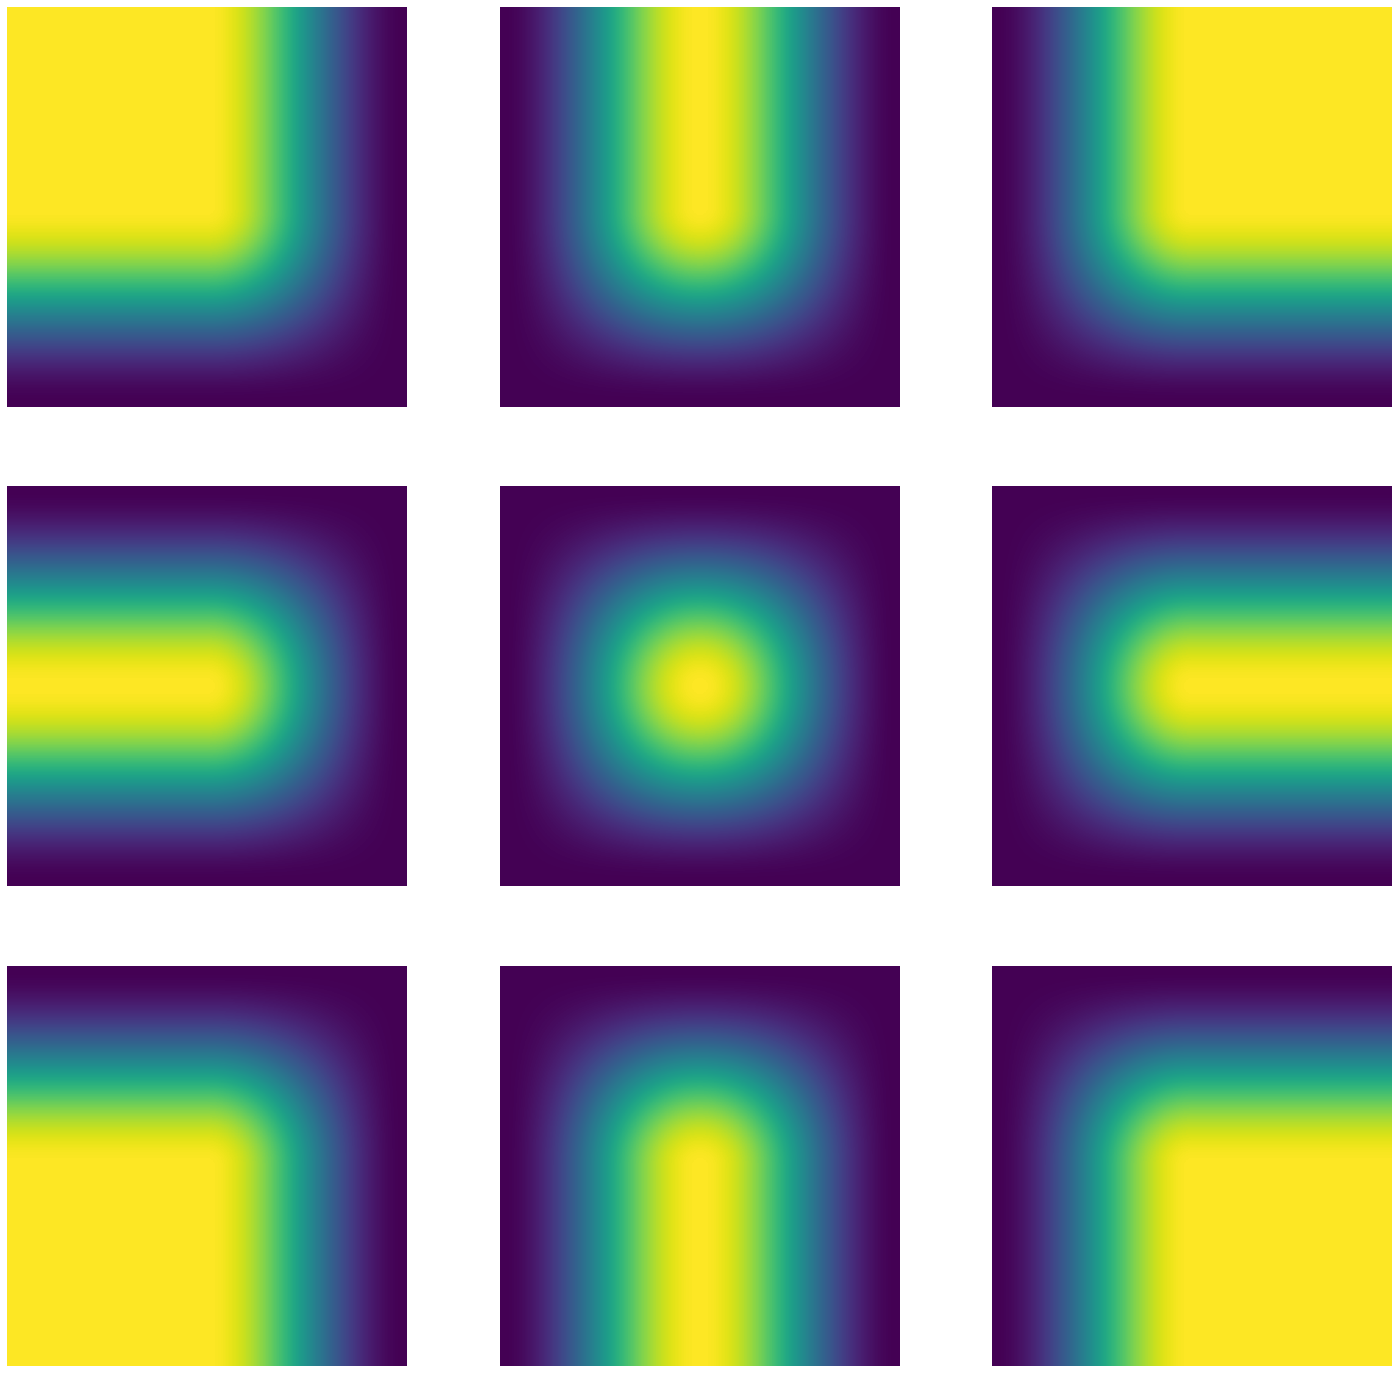

In [ ]:
f2, axarr2 = plt.subplots(nrows=3, ncols=3, figsize=(25, 25))
axarr2[0, 0].imshow(hann_wnd_up_l, cmap='viridis')
axarr2[1, 0].imshow(hann_wnd_left, cmap='viridis')
axarr2[2, 0].imshow(hann_wnd_down_l, cmap='viridis')
axarr2[0, 1].imshow(hann_wnd_up, cmap='viridis')
axarr2[1, 1].imshow(hann_wnd_b, cmap='viridis')
axarr2[2, 1].imshow(hann_wnd_down, cmap='viridis')
axarr2[0, 2].imshow(hann_wnd_up_r, cmap='viridis')
axarr2[1, 2].imshow(hann_wnd_right, cmap='viridis')
axarr2[2, 2].imshow(hann_wnd_down_r, cmap='viridis')
axarr2[0, 0].axis('off')
axarr2[1, 0].axis('off')
axarr2[2, 0].axis('off')
axarr2[0, 1].axis('off')
axarr2[1, 1].axis('off')
axarr2[2, 1].axis('off')
axarr2[0, 2].axis('off')
axarr2[1, 2].axis('off')
axarr2[2, 2].axis('off')
plt.savefig('Okna Hanna.png', dpi=300, bbox_inches='tight')

Funkcja choose\_proper\_hann służy do wyboru odpowiedniego dwuwymiarowego okna Hanna, w zależności od tego, z której części bazowego zdjęcia walidacyjnego dana podpróbka została pobrana.

In [ ]:
def choose_proper_hann(i, j, max_shp):
  if j == 0 and i == 0:
    curr_hann = hann_wnd_up_l
  elif i == 0 and j != 0 and j != max_shp - 1:
    curr_hann = hann_wnd_up
  elif i == 0 and j == max_shp - 1:
    curr_hann = hann_wnd_up_r
  elif j == 0 and i != 0 and i != max_shp - 1:
    curr_hann = hann_wnd_left
  elif j == 0 and i == max_shp - 1:
    curr_hann = hann_wnd_down_l
  elif j == max_shp - 1 and i != 0 and i != max_shp - 1:
    curr_hann = hann_wnd_right
  elif j == max_shp - 1 and i == max_shp - 1:
    curr_hann = hann_wnd_down_r
  elif j != 0 and j != max_shp - 1  and i == max_shp - 1:
    curr_hann = hann_wnd_down
  else:
    curr_hann = hann_wnd_b
  return curr_hann

Przy pomocy funkcji get\_fin\_mask realizowane jest generowanie finalnej maski dla poszczególnych zdjęć ze zbioru walidacyjnego. Funkcja ta przechodzi przez predykcje wygenerowane dla wszystkich podpróbek, przemnaża je przez odpowiednie okna Hanna i nanosi we właściwym miejscu finalnej maski 5000x5000. 

In [ ]:
def get_fin_mask(fin_preds, Gy, Gx, wnd_h, wnd_w, img_h, img_w, Sy, Sx):
  rshp_fin_preds = fin_preds.reshape((Gy, Gx, wnd_h, wnd_w))
  fin_image_mask = np.zeros((img_h, img_w))
  end_x = sample_res
  strt_x = 0
  
  for i in range(Gy):
    end_y = sample_res
    strt_y = 0
    for j in range(Gx):
      curr_p = rshp_fin_preds[i, j]
      curr_h = choose_proper_hann(i, j, Gy)
      fin_image_mask[strt_x:end_x, strt_y:end_y] += np.multiply(curr_p, 
                                                                curr_h)
      strt_y += Sy
      end_y += Sy
    strt_x += Sx
    end_x += Sx

  return fin_image_mask

Poniższe obrazy wizualizują skuteczność sieci GML-Net w detekcji budynków na zdjęciach lotniczych na przykładzie losowo wybranego zdjęcia ze zbioru walidacyjnego.

In [ ]:
imgs_arr = pd.read_csv("m_inf_v.csv", header=None).values
img_n = 1
final_f1s = []
final_iou = []
final_acc = []
final_ssim = []
pred_time = []
img_time = []
img, msk, wnd_h, wnd_w, nm_cls, img_h, img_w, Sy, Sx = g_prms(imgs_arr, 
                                                              img_n)
wnd_img, Gx, Gy = get_wnds(img, msk, wnd_h, wnd_w, nm_cls, img_h, img_w, 
                           Sy, Sx)
fin_preds = get_all_preds(wnd_img)
f_img_msk = get_fin_mask(fin_preds, Gy, Gx, wnd_h, wnd_w, img_h, img_w, 
                         Sy, Sx)

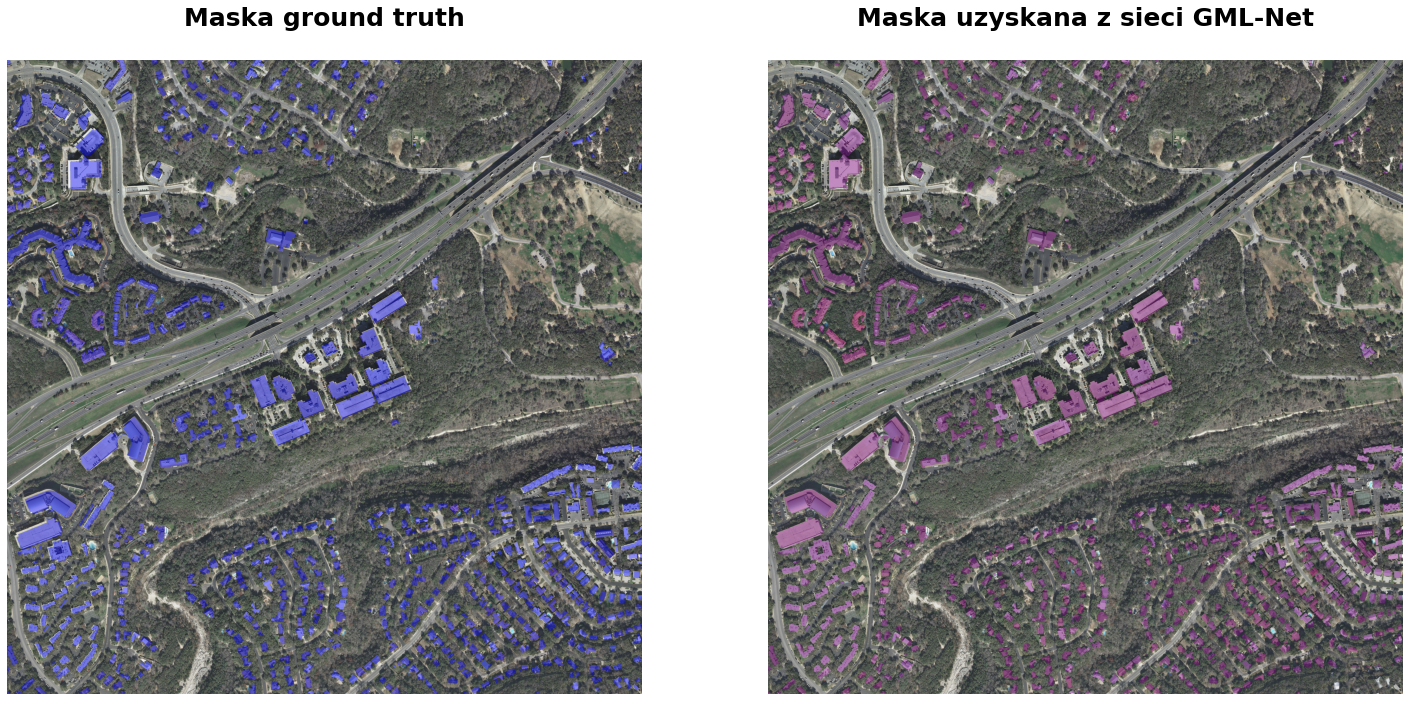

In [ ]:
img_rgba = np.ones((img.shape[0], img.shape[1], 4), dtype=np.uint8) * 255
img_rgba[..., :3] = img
mask_rgba = np.zeros((img.shape[0], img.shape[1], 4), dtype=np.uint8)
mask_rgba[msk == 255, ...] = [0, 0, 255, 180]
pred_mask_rgba = np.zeros((img.shape[0], img.shape[1], 4), dtype=np.uint8)
pred_mask_rgba[f_img_msk > loss_thres, ...] = [128, 0, 128, 180]
f2, axarr2 = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axarr2[0].set_title("Maska ground truth\n", color='black', fontweight="bold",
                    fontsize=25)
axarr2[0].imshow(img_rgba)
axarr2[0].imshow(mask_rgba, alpha=0.6)
axarr2[0].axis('off')
axarr2[1].imshow(img_rgba)
axarr2[1].imshow(pred_mask_rgba, alpha=0.6)
axarr2[1].axis('off')
axarr2[1].set_title("Maska uzyskana z sieci GML-Net\n", color='black', 
                    fontweight="bold", fontsize=25)
plt.savefig('Predykacja vs. maska.png', dpi=300, bbox_inches='tight')

Porównanie wizualne powyższych zdjęć wskazuje, iż różnice w predykcji maski przez sieć GML-Net a faktyczną maską ground truth nie są istotne.

In [ ]:
def calc_metrics(f_img_msk, msk):
  prd2 = f_img_msk > loss_thres
  trgt2 = msk == 255
  intrs = (prd2 * trgt2).sum()
  f1s = torch.true_divide(2. * intrs, prd2.sum() + trgt2.sum())
  f1s = f1s.cpu().numpy().item(0)
  union = (prd2 + trgt2).sum()
  iou = torch.true_divide(intrs, union).cpu().numpy().item(0)
  acc = torch.true_divide(intrs + (~prd2 * ~trgt2).sum(), prd2.size)
  acc = acc.cpu().numpy().item(0)
  prd3 = torch.tensor(np.expand_dims(prd2, axis=0)).cuda()
  trgt3 = torch.tensor(np.expand_dims(trgt2, axis=0)).cuda()
  ssim = ssim_index(prd3, trgt3).cpu().numpy().item(0)

  return f1s, iou, acc, ssim

f1s, iou, acc, ssim = calc_metrics(f_img_msk, msk)

(0.8894951939582825, 0.8009827733039856, 0.976598858833313, 0.9626415371894836)

Wartości poszczególnych metryk wyliczone dla powyższego losowego zdjęcia pochodzącego ze zbioru walidacyjnego potwierdzają obserwacje wizualne wskazujące na dobrą jakość predykcji. Wartości tych metryk są następujące: OA = 97,66%, IoU = 80,10%, F1S = 88,95% oraz SSIM = 96,26%.

In [ ]:
for i in range(len(imgs_arr)):
  since0 = time.time()
  img, msk, wnd_h, wnd_w, nm_cls, img_h, img_w, Sy, Sx = g_prms(imgs_arr, i)
  wnd_i, Gx, Gy = get_wnds(img, msk, wnd_h, wnd_w, nm_cls, img_h, img_w, 
                           Sy, Sx)
  fin_p = get_all_preds(wnd_i)
  since1 = time.time()
  f_img_msk = get_fin_mask(fin_p, Gy, Gx, wnd_h, wnd_w, img_h, img_w,
                           Sy, Sx)
  pred_time += [time.time() - since1]
  img_time += [time.time() - since0]
  f1s, iou, acc, ssim = calc_metrics(f_img_msk, msk)                                                        
  final_f1s += [f1s]
  final_iou += [iou]
  final_acc += [acc]
  final_ssim += [ssim]

joined_time = sum(img_time)
av_img_time = sum(img_time) / len(images_arr)
avg_pred_time = sum(pred_time) / (len(images_arr) * Gx * Gy)

Sieć GML-Net osiągnęła zadowalającą finalną skuteczność na zbiorze walidacyjnym przy predykcji masek o rozmiarach 5000x5000 - uzyskano następujące finalne wartości metryk: OA = 96,44%, IoU = 75,97%, F1S = 86,07% oraz SSIM = 94,55%. Jak można się było spodziewać metryki jakości predykcji modelu wyliczane na poziomie pełnych zdjęć o wysokiej rozdzielczości są gorsze od metryk wyliczanych na poziomie podpróbek o rozdzielczości 256x256. Ogólna dokładność pogarsza się o 0,64 punktu procentowego, współczynnik podobieństwa Jaccarda spada aż o 6,45 p.p., wynik F1 jest niższy o 2,35 p.p. a indeks podobieństwa strukturalnego jest gorszy o 0,91 p.p.

$$\begin{array}{|c|c|c|}
 \hline  Rodzaj\ metryki & Wyniki\ dla\ masek\ 256x256 & Wyniki\ dla\ masek\  5000x5000\\ 
 \hline 
OA & 97,08\% & 96,44\% \\
 \hline 
IoU & 82,42\% & 75,97\% \\
 \hline 
F1S & 88,22\% & 86,07\% \\
 \hline 
SSIM & 95,46\% & 94,55\% \\
 \hline 
\end{array}$$

W niniejszym rozdziale szczegółowo opisany został proces konstrukcji głębokiej sieci neuronowej o nazwie GML-Net oraz wyniki, które ta sieć generuje dla zbioru walidacyjnego $Inria Aerial Image Labeling Dataset na poziomie podpróbek o rozdzielczości 256x256 oraz na poziomie pełnych zdjęć o rozdzielczości 5000x5000. W kolejnym rozdziale wyniki te zostaną porównane z wynikami uzyskanymi przez innych autorów zajmujących się zagadnieniem detekcji budynków na zdjęciach lotniczych.
